In [1]:
import numpy as np
import glob
import matplotlib.pyplot as plt
import yaml

In [13]:
num_folds = 4
num_configs = 54

val_losses = []
val_losses_pi0 = []
val_losses_pion = []

for i in range(num_configs):
    config_val_loss = []
    config_val_loss_pi0 = []
    config_val_loss_pion = []
    
    for j in range(num_folds):
        file = 'results/Block_regress_config_{}_fold_{}/losses.npz'.format(i, j)
        config_val_loss.append(np.load(file)['validation'].mean(axis=-1)[-1])
        preds = np.load('results/Block_regress_config_{}_fold_{}/predictions.npz'.format(i, j))
        targets = preds['targets']
        outputs = preds['outputs']
        pi0_inds = (targets[:,1] == 0)
        pi0_mae = np.mean(np.abs(np.log10(targets[pi0_inds,0]) - np.log10(outputs[pi0_inds,0])))
        pion_mae = np.mean(np.abs(np.log10(targets[~pi0_inds,0]) - np.log10(outputs[~pi0_inds,0])))
        
        config_val_loss_pi0.append(pi0_mae)
        config_val_loss_pion.append(pion_mae)
    
    config_val_loss = np.array(config_val_loss)
    config_val_loss_pi0 = np.array(config_val_loss_pi0)
    config_val_loss_pion = np.array(config_val_loss_pion)
    
    val_losses.append([config_val_loss.mean(), config_val_loss.mean() - config_val_loss.min(), config_val_loss.max() - config_val_loss.mean()])
    
    val_losses_pi0.append([config_val_loss_pi0.mean(), config_val_loss_pi0.mean() - config_val_loss_pi0.min(), config_val_loss_pi0.max() - config_val_loss_pi0.mean()])
    val_losses_pion.append([config_val_loss_pion.mean(), config_val_loss_pion.mean() - config_val_loss_pion.min(), config_val_loss_pion.max() - config_val_loss_pion.mean()])

    
val_losses = np.array(val_losses)
val_losses_pi0 = np.array(val_losses_pi0)
val_losses_pion = np.array(val_losses_pion)

In [9]:
np.argmin(val_losses[:,0])

46

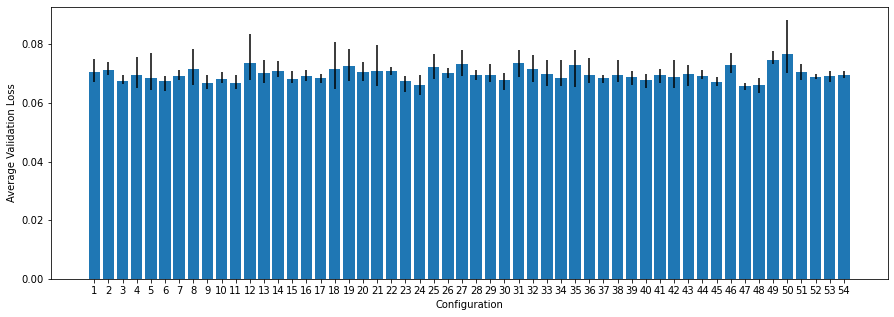

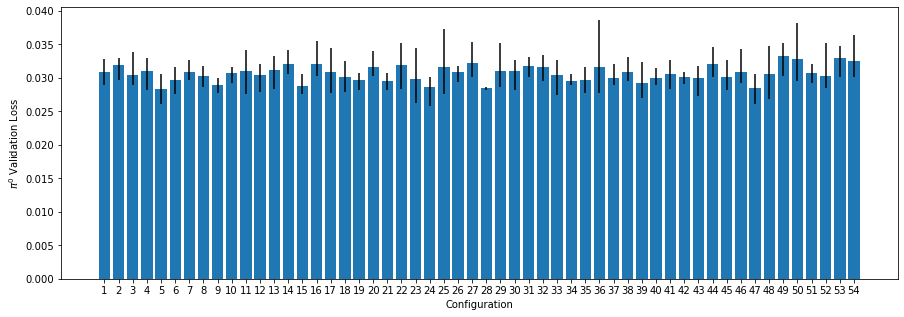

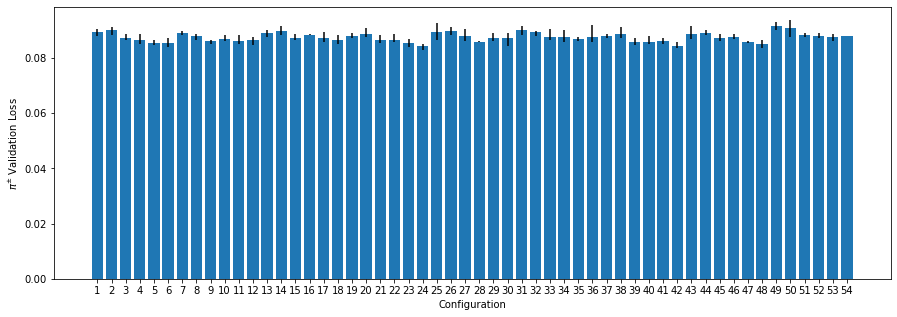

In [14]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(num_configs)+1, val_losses[:,0], yerr=val_losses[:,1:].T, align='center')
plt.xticks(ticks=np.arange(num_configs)+1)
plt.xlabel('Configuration')
plt.ylabel('Average Validation Loss')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(num_configs)+1, val_losses_pi0[:,0], yerr=val_losses_pi0[:,1:].T, align='center')
plt.xticks(ticks=np.arange(num_configs)+1)
plt.xlabel('Configuration')
plt.ylabel('$\\pi^{0}$ Validation Loss')
plt.show()

plt.figure(figsize=(15,5))
plt.bar(np.arange(num_configs)+1, val_losses_pion[:,0], yerr=val_losses_pion[:,1:].T, align='center')
plt.xticks(ticks=np.arange(num_configs)+1)
plt.xlabel('Configuration')
plt.ylabel('$\\pi^{\\pm}$ Validation Loss')
plt.show()

In [5]:
config_files = [yaml.load(open('configs/regress_config_{}_fold_0.yaml'.format(i), 'r')) for i in range(num_configs)]

/usr/workspace/karande1/opence/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [12]:
config_files[46]

{'data': {'already_preprocessed': True,
  'batch_size': 1024,
  'data_dir': '/usr/workspace/hip/ML4Jets/regression_images/',
  'fold_ind': 0,
  'num_folds': 4,
  'num_procs': 16,
  'num_train_files': 40,
  'output_dir': 'preprocessed_data/',
  'preprocess': True,
  'shuffle': False},
 'model': {'block_type': 'graphnet',
  'concat_input': True,
  'edge_block_opt': {'use_edges': True,
   'use_globals': True,
   'use_receiver_nodes': True,
   'use_sender_nodes': True},
  'global_block_opt': {'use_edges': False,
   'use_globals': True,
   'use_nodes': True},
  'latent_size': 64,
  'node_block_opt': {'use_globals': True,
   'use_nodes': True,
   'use_received_edges': True,
   'use_sent_edges': False},
  'num_blocks': 4,
  'num_layers': 4,
  'reducer': 'mean'},
 'training': {'alpha': 1,
  'epochs': 10,
  'gpu': 0,
  'learning_rate': 0.001,
  'log_freq': 1,
  'save_dir': 'results/'}}

In [7]:
block_type = {'graphnet': []}  # , 'deepsets': []}
num_blocks = {2: [], 3: [], 4: []}
num_layers = {2: [], 4: [], 6: []}
latent_size = {16: [], 32: [], 64: []}
concat_input = {True: []}  # , False: []}
reducer = {'mean': [], 'sum': []}

for i, config in enumerate(config_files):
    block_type[config['model']['block_type']].append(val_losses[i, 0])
    num_blocks[config['model']['num_blocks']].append(val_losses[i, 0])
    num_layers[config['model']['num_layers']].append(val_losses[i, 0])
    latent_size[config['model']['latent_size']].append(val_losses[i, 0])
    concat_input[config['model']['concat_input']].append(val_losses[i, 0])
    reducer[config['model']['reducer']].append(val_losses[i, 0])

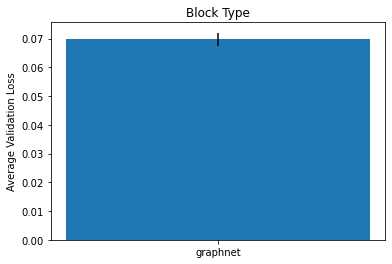

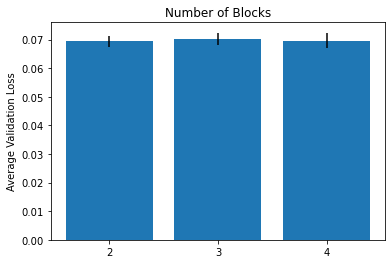

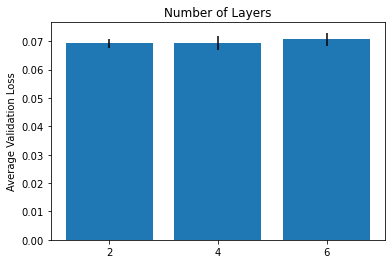

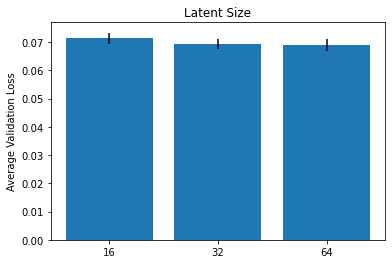

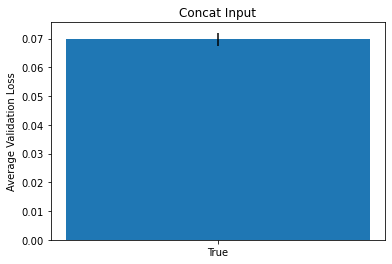

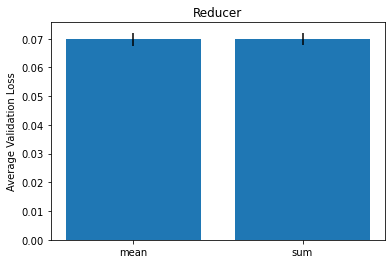

In [8]:
titles = ['Block Type', 'Number of Blocks', 'Number of Layers', 'Latent Size', 'Concat Input', 'Reducer']
opts = [block_type, num_blocks, num_layers, latent_size, concat_input, reducer]

for title, data in zip(titles, opts):
    num_opts = len(data.keys())
    opt_means = [np.mean(losses) for losses in data.values()]
    opt_stds = [np.std(losses) for losses in data.values()]

    plt.bar(np.arange(len(data.keys())), opt_means, yerr=opt_stds, align='center')
    plt.xticks(ticks=np.arange(num_opts), labels=data.keys())
    plt.title(title)
    plt.ylabel('Average Validation Loss')
    plt.show()